<a href="https://colab.research.google.com/github/Trapti04/Machine_Learning_Colab_Workbooks/blob/master/CIFAR_dataset__deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images of everyday objects using a neural network

The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc. 

In this assignment, you will:

1. Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
2. Set up a training pipeline to train a neural network on a GPU
2. Experiment with different network architectures & hyperparameters

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end. Try to experiment with different network structures and hypeparameters to get the lowest loss.

You might find these notebooks useful for reference, as you work through this notebook:

- https://jovian.ml/aakashns/04-feedforward-nn
- https://jovian.ml/aakashns/fashion-feedforward-minimal

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## Exploring the CIFAR10 dataset

In [3]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


**Q: How many images does the training dataset contain?**

In [4]:
dataset_size = len(dataset)
dataset_size

50000

**Q: How many images does the test dataset contain?**

In [5]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

**Q: How many output classes does the dataset contain? Can you list them?**

Hint: Use `dataset.classes`

In [6]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
num_classes = len(dataset.classes)
num_classes

10

**Q: What is the shape of an image tensor from the dataset?**

In [8]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 6
Label (textual): frog


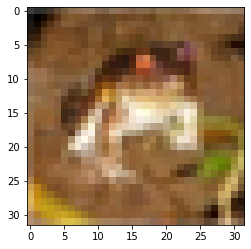

In [9]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

**(Optional) Q: Can you determine the number of images belonging to each class?**

Hint: Loop through the dataset.

In [10]:
# declar a map to store class name as key and value as total class count
d = {}
 # enter a new key for each new lbl and update is value  with a count
 # if the key already exists then just incremet the counter
for img,lbl in dataset:
    if lbl not in d.keys():
        d[lbl] = 0
    d[lbl] += 1
    


In [11]:
d

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

## Preparing the data for training

We'll use a validation set with 5000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [12]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

Let's use the `random_split` method to create the training & validation sets

In [13]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders to load the data in batches.

In [14]:
batch_size= 64 #max accuracy .53 with 128, max accuracy .52 with 64, sdg, 20,20,20 epochs of 0.1,0.5,0.01 lr

In [15]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

images.shape: torch.Size([64, 3, 32, 32])


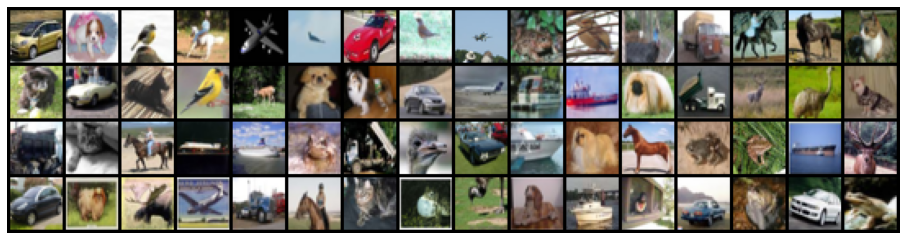

In [16]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Can you label all the images by looking at them? Trying to label a random sample of the data manually is a good way to estimate the difficulty of the problem, and identify errors in labeling, if any.

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # first output is the max value and second is the index of max value. We are interested in index position of max value.
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc} # https://stackoverflow.com/questions/56816241/difference-between-detach-and-with-torch-nograd-in-pytorch
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies # https://stackoverflow.com/questions/69220221/use-of-torch-stack for diff between stack and contactenation
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [19]:
# showing difference between stacking and concat. Not  in the stack function they expect tuples  or more of tensor objects. Stacking adds a dim; concat is along one of the dim.
a_list = [3,4,5,6,7] 
b_list = [10,9,8,7,6]
a_tensor = torch.Tensor(a_list)
b_tensor = torch.Tensor(b_list)
l_stacked = torch.stack((a_tensor, b_tensor))
l_concat = torch.concat((a_tensor,b_tensor))
l_stacked

tensor([[ 3.,  4.,  5.,  6.,  7.],
        [10.,  9.,  8.,  7.,  6.]])

In [20]:
l_concat

tensor([ 3.,  4.,  5.,  6.,  7., 10.,  9.,  8.,  7.,  6.])

We can also use the exact same training loop as before. I hope you're starting to see the benefits of refactoring our code into reusable functions.

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): # torch.optim.SGD= .50, ASGD= .49. accuracy,torch.optim.RMSprop,torch.optim.Adam= no learning
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.

In [22]:
torch.cuda.is_available()

True

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [26]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [28]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch

What's the highest validation accuracy you can get to? **Can you get to 50% accuracy? What about 60%?**

In [29]:
in_size = 3*32*32
out_size = 10


**Q: Extend the `ImageClassificationBase` class to complete the model definition.**

Hint: Define the `__init__` and `forward` methods.

In [30]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        ???
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        ???
        return out

In [31]:
hidden_size_1 = 256 #128
hidden_size_2 = 128 #64
hidden_size_3 = 64 

In [32]:
class CIFAR10Model(ImageClassificationBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size_1, hidden_size_2, hidden_size_3, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size_1)
        # introducing drop out for regularization
        self.reg1 = nn.Dropout(p= 0)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        #reg layer
        self.reg2 = nn.Dropout(p= 0)
        # hidden layer 3
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3)
        #reg layer
        self.reg3 = nn.Dropout(p= 0)
        # output layer
        self.linear4 = nn.Linear(hidden_size_3, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        #apply dropout
        out = self.reg1(out)
        #Get intermediate outputs froom next hidden layer
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        #Get intermediate outputs froom next hidden layer
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        #apply dropout
        out = self.reg3(out)
        # Get predictions using output layer
        out = self.linear4(out)
        return out
    

You can now instantiate the model, and move it the appropriate device.

In [33]:
model = to_device(CIFAR10Model(in_size, hidden_size_1, hidden_size_2, hidden_size_3, out_size), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [34]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09433593600988388, 'val_loss': 2.3093202114105225}]

**Q: Train the model using the `fit` function to reduce the validation loss & improve accuracy.**

Leverage the interactive nature of Jupyter to train the model in multiple phases, adjusting the no. of epochs & learning rate each time based on the result of the previous training phase.

In [35]:
history += fit(100, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.3005, val_acc: 0.1002
Epoch [1], val_loss: 2.2947, val_acc: 0.1061
Epoch [2], val_loss: 2.2884, val_acc: 0.1205
Epoch [3], val_loss: 2.2805, val_acc: 0.1436
Epoch [4], val_loss: 2.2700, val_acc: 0.1650
Epoch [5], val_loss: 2.2553, val_acc: 0.1924
Epoch [6], val_loss: 2.2355, val_acc: 0.1879
Epoch [7], val_loss: 2.2096, val_acc: 0.1951
Epoch [8], val_loss: 2.1782, val_acc: 0.2133
Epoch [9], val_loss: 2.1440, val_acc: 0.2244
Epoch [10], val_loss: 2.1100, val_acc: 0.2457
Epoch [11], val_loss: 2.0792, val_acc: 0.2555
Epoch [12], val_loss: 2.0536, val_acc: 0.2619
Epoch [13], val_loss: 2.0319, val_acc: 0.2641
Epoch [14], val_loss: 2.0161, val_acc: 0.2639
Epoch [15], val_loss: 1.9980, val_acc: 0.2686
Epoch [16], val_loss: 1.9844, val_acc: 0.2766
Epoch [17], val_loss: 1.9719, val_acc: 0.2824
Epoch [18], val_loss: 1.9605, val_acc: 0.2838
Epoch [19], val_loss: 1.9548, val_acc: 0.2895
Epoch [20], val_loss: 1.9402, val_acc: 0.2941
Epoch [21], val_loss: 1.9320, val_acc: 0.300

In [36]:
#history += fit(20, 0.1, model, train_loader, val_loader)

In [37]:
history += fit(20, 0.0005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5793, val_acc: 0.4330
Epoch [1], val_loss: 1.5846, val_acc: 0.4334
Epoch [2], val_loss: 1.5654, val_acc: 0.4420
Epoch [3], val_loss: 1.5748, val_acc: 0.4340
Epoch [4], val_loss: 1.5636, val_acc: 0.4414
Epoch [5], val_loss: 1.5612, val_acc: 0.4430
Epoch [6], val_loss: 1.5628, val_acc: 0.4414
Epoch [7], val_loss: 1.5609, val_acc: 0.4338
Epoch [8], val_loss: 1.5673, val_acc: 0.4391
Epoch [9], val_loss: 1.5547, val_acc: 0.4453
Epoch [10], val_loss: 1.5632, val_acc: 0.4387
Epoch [11], val_loss: 1.5515, val_acc: 0.4412
Epoch [12], val_loss: 1.5546, val_acc: 0.4443
Epoch [13], val_loss: 1.5510, val_acc: 0.4447
Epoch [14], val_loss: 1.5525, val_acc: 0.4443
Epoch [15], val_loss: 1.5485, val_acc: 0.4545
Epoch [16], val_loss: 1.5523, val_acc: 0.4395
Epoch [17], val_loss: 1.5499, val_acc: 0.4516
Epoch [18], val_loss: 1.5685, val_acc: 0.4434
Epoch [19], val_loss: 1.5407, val_acc: 0.4516


In [38]:
#history += fit(10, 0.1, model, train_loader, val_loader)

In [39]:
history += fit(20, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5389, val_acc: 0.4514
Epoch [1], val_loss: 1.5390, val_acc: 0.4531
Epoch [2], val_loss: 1.5387, val_acc: 0.4535
Epoch [3], val_loss: 1.5391, val_acc: 0.4561
Epoch [4], val_loss: 1.5382, val_acc: 0.4529
Epoch [5], val_loss: 1.5377, val_acc: 0.4537
Epoch [6], val_loss: 1.5373, val_acc: 0.4547
Epoch [7], val_loss: 1.5370, val_acc: 0.4559
Epoch [8], val_loss: 1.5362, val_acc: 0.4531
Epoch [9], val_loss: 1.5361, val_acc: 0.4533
Epoch [10], val_loss: 1.5371, val_acc: 0.4561
Epoch [11], val_loss: 1.5361, val_acc: 0.4555
Epoch [12], val_loss: 1.5354, val_acc: 0.4555
Epoch [13], val_loss: 1.5347, val_acc: 0.4568
Epoch [14], val_loss: 1.5343, val_acc: 0.4570
Epoch [15], val_loss: 1.5354, val_acc: 0.4541
Epoch [16], val_loss: 1.5342, val_acc: 0.4564
Epoch [17], val_loss: 1.5346, val_acc: 0.4520
Epoch [18], val_loss: 1.5371, val_acc: 0.4523
Epoch [19], val_loss: 1.5332, val_acc: 0.4535


In [40]:
#history += fit(10, 0.005, model, train_loader, val_loader)

Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. You can train some more if you can see the scope for further improvement.

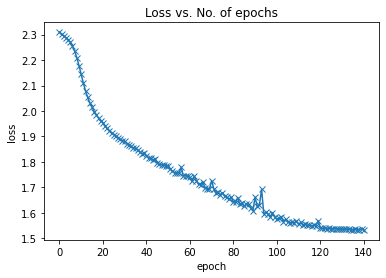

In [41]:
plot_losses(history)

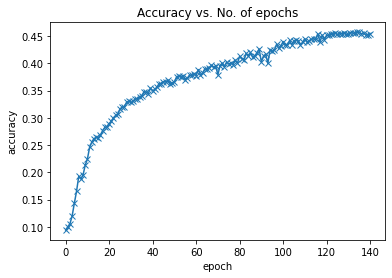

In [42]:
plot_accuracies(history)

Finally, evaluate the model on the test dataset report its final performance.

In [49]:
evaluate(model, test_loader)

{'val_acc': 0.4600474536418915, 'val_loss': 1.5070174932479858}

Are you happy with the accuracy? Record your results by completing the section below, then you can come back and try a different architecture & hyperparameters.

## Recoding your results

As your perform multiple experiments, it's important to record the results in a systematic fashion, so that you can review them later and identify the best approaches that you might want to reproduce or build upon later. 

**Q: Describe the model's architecture with a short summary.**

E.g. `"3 layers (16,32,10)"` (16, 32 and 10 represent output sizes of each layer)

In [44]:
arch = "3 layers (64,32,10)"

**Q: Provide the list of learning rates used while training.**

In [45]:
lrs = [0.2,0.1, 0.05, 0.01]

**Q: Provide the list of no. of epochs used while training.**

In [46]:
epochs = [10,5,5,10]

**Q: What were the final test accuracy & test loss?**

In [47]:
test_acc = 0.5064
test_loss = 1.408

Finally, let's save the trained model weights to disk, so we can use this model later.

In [48]:
torch.save(model.state_dict(), 'cifar10-feedforwardv2.pth')

Once committed, you can find the recorded metrics & hyperprameters in the "Records" tab on Jovian. You can find the saved model weights in the "Files" tab.

## Continued experimentation

Now go back up to the **"Training the model"** section, and try another network architecture with a different set of hyperparameters. As you try different experiments, you will start to build an undestanding of how the different architectures & hyperparameters affect the final result. Don't worry if you can't get to very high accuracy, we'll make some fundamental changes to our model in the next lecture.

Once you have tried multiple experiments, you can compare your results using the **"Compare"** button on Jovian.

![compare-example](https://i.imgur.com/ltdYnSN.png)

## (Optional) Write a blog post

Writing a blog post is the best way to further improve your understanding of deep learning & model training, because it forces you to articulate your thoughts clearly. Here'are some ideas for a blog post:
- Report the results given by different architectures on the CIFAR10 dataset
- Apply this training pipeline to a different dataset (it doesn't have to be images, or a classification problem) 
- Improve upon your model from Assignment 2 using a feedfoward neural network, and write a sequel to your previous blog post
- Share some Strategies for picking good hyperparameters for deep learning
- Present a summary of the different steps involved in training a deep learning model with PyTorch
- Implement the same model using a different deep learning library e.g. Keras ( https://keras.io/ ), and present a comparision.
